In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from preprocess_data import get_cleaned_data, lemmatize_words
from sklearn.metrics import jaccard_score
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


path = './data/pp_doc_dict.pickle'
data = get_cleaned_data(path) # {company: [(year1, wordlist1), (year2, wordlist2)]}
data = {k: sorted(v, key=lambda x: x[0]) for k, v in data.items()}

sentiments = ['negative', 'positive', 'uncertainty', 'litigious']
new_sentiments = ['negative', 'positive', 'uncertainty']

def get_sentiments_df(sentiments):
    sentiments_df = pd.read_csv("./data/Loughran-McDonald_MasterDictionary_1993-2021.csv")
    # Convert column names to lowercase
    sentiments_df.columns = [column.lower() for column in sentiments_df.columns]
    # Remove other columns except the ones about sentiment
    sentiments_df = sentiments_df[sentiments+['word']]
    # Convert the column values to boolean type
    sentiments_df[sentiments] = sentiments_df[sentiments].astype(bool)
    # Convert the words to lowercase
    sentiments_df['word'] = sentiments_df['word'].str.lower()
    # Remove words who have False in all the sentiments
    sentiments_df = sentiments_df[(sentiments_df[sentiments]).any(axis=1)]
    # Lemmatize the words the same as your corpus
    sentiments_df['word'] = lemmatize_words(sentiments_df['word'])
    # Drop duplicates 
    sentiments_df = sentiments_df.drop_duplicates('word')

    return sentiments_df

sentiments_df = get_sentiments_df(sentiments)
sentiments_df.head()

,negative,positive,uncertainty,litigious,word
9,True,False,False,False,abandon
12,True,False,False,False,abandonment
13,True,False,False,False,abandonments
51,True,False,False,False,abdicate
54,True,False,False,False,abdication


In [2]:
# Assuming your dataframe is named 'df'
# 'word' column contains words, and other columns contain True/False values
# Example dataframe:
#    word  positive  negative  litigious  uncertainty
# 0  word1      True     False       True         True
# 1  word2     False      True      False        False
# 2  word3      True      True      False         True
# 3  word4     False     False      False        False
# ...

# Count the number of True values in each row
row_true_counts = sentiments_df.iloc[:, :-1].sum(axis=1)

# Filter rows where the count is greater than 1
filtered_df = sentiments_df[row_true_counts > 1]

# Print the resulting dataframe
filtered_df[filtered_df['positive']==True]

,negative,positive,uncertainty,litigious,word
6375,False,True,False,True,beneficial


In [3]:
new_sentiments_df = sentiments_df
sentiments_df.loc[sentiments_df['word'] == 'beneficial', 'negative'] = False
sentiments_df.loc[sentiments_df['litigious'], 'negative'] = True
new_sentiments_df.loc[(new_sentiments_df['uncertainty'] & new_sentiments_df['negative']), 'uncertainty'] = False
new_sentiments_df = new_sentiments_df.drop('litigious', axis=1)
new_sentiments_df

,negative,positive,uncertainty,word
9,True,False,False,abandon
12,True,False,False,abandonment
13,True,False,False,abandonments
51,True,False,False,abdicate
54,True,False,False,abdication
...,...,...,...,...
86080,True,False,False,wrongdoing
86081,True,False,False,wrongdoings
86085,True,False,False,wrongful
86086,True,False,False,wrongfully


In [4]:
new_sentiments_pos = new_sentiments_df['positive'].sum()
new_sentiments_neg = new_sentiments_df['negative'].sum()
new_sentiments_unc = new_sentiments_df['uncertainty'].sum()
new_sentiments_pos, new_sentiments_neg, new_sentiments_unc

(249, 2145, 198)

In [5]:
def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    # reference : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    c_vectorizer = CountVectorizer(vocabulary=sentiment_words.values)
    # tokenization
    X = c_vectorizer.fit_transform(docs)
    
    return X.toarray()

In [6]:
sentiment_bow = {}
for company, datalst in data.items():
    preprocessed_docs = [" ".join(wordlst) for year, wordlst in datalst]
    sentiment_bow[company] = {
        sentiment: get_bag_of_words(sentiments_df[sentiments_df[sentiment]]['word'], preprocessed_docs)
        for sentiment in sentiments}
    
sentiment_bow['AAPL']

{'negative': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 'positive': array([[ 9,  0,  0, ...,  0,  0,  0],
        [ 9,  0,  0, ...,  0,  0,  0],
        [ 9,  0,  0, ...,  0,  0,  0],
        ...,
        [ 9,  0,  0, ...,  0,  0,  0],
        [10,  0,  0, ...,  0,  0,  0],
        [ 9,  0,  0, ...,  0,  0,  0]], dtype=int64),
 'uncertainty': array([[ 0,  0,  0, ...,  0,  8,  0],
        [ 0,  0,  0, ...,  0, 12,  0],
        [ 0,  0,  0, ...,  0, 10,  0],
        ...,
        [ 0,  0,  0, ...,  0,  9,  0],
        [ 0,  0,  0, ...,  0,  6,  0],
        [ 0,  0,  0, ...,  0,  7,  0]], dtype=int64),
 'litigious': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..

In [7]:
def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    
    # TODO: Implement
    jaccard_sim = []
    boolean_bow = bag_of_words_matrix.astype(bool)
    
    # -1 to avoid out of bounds error
    for i in range(bag_of_words_matrix.shape[0]-1):
        jaccard_sim.append(jaccard_score(boolean_bow[i], boolean_bow[i+1]))
        
    
    return jaccard_sim

Length of similarities list =  4
Length of labels 4


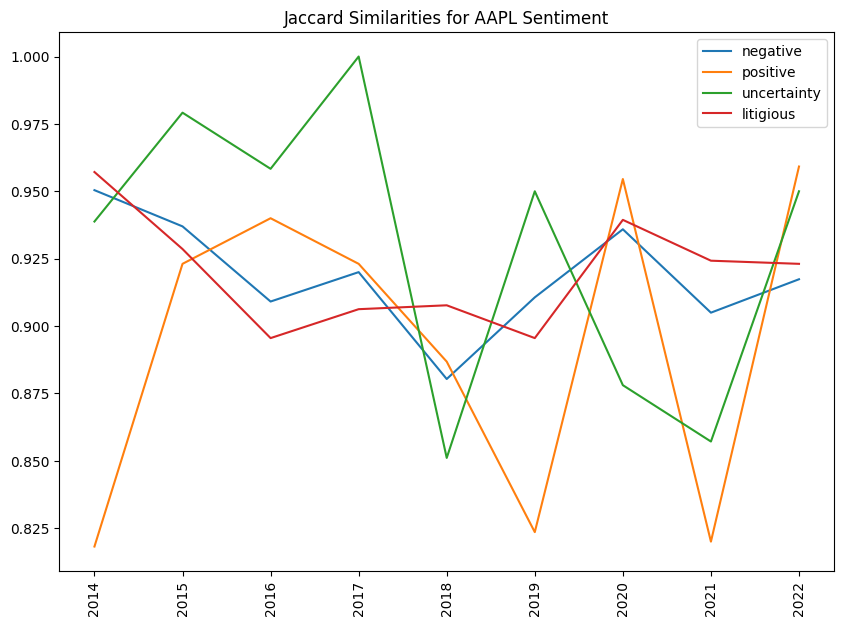

In [8]:
# Get dates for the universe
file_dates = {
    company: [year for year, doc in datalst]
    for company, datalst in data.items()}  

jaccard_similarities = {
    company: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for company, ten_k_sentiments in sentiment_bow.items()}

def plot_similarities(similarities_list, dates, title, labels):
    print("Length of similarities list = ", len(similarities_list))
    print("Length of labels", len(labels))
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(10, 7))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend()
        plt.xticks(rotation=90)

    plt.show()

example_ticker = 'AAPL'
plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)


In [9]:
def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    tfidf_vector = TfidfVectorizer(vocabulary=sentiment_words.values)
    X = tfidf_vector.fit_transform(docs)
    
    return X.toarray()

sentiment_tfidf_ten_ks = {}

for company, datalst in data.items():
    lemma_docs = [' '.join(doc) for year, doc in datalst]
    
    sentiment_tfidf_ten_ks[company] = {
        sentiment: get_tfidf(sentiments_df[sentiments_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

sentiment_tfidf_ten_ks['AAPL']

{'negative': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'positive': array([[0.11034659, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.10670518, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.10750083, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.1389658 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.17340361, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.15521255, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'uncertainty': array([[0.        , 0.        , 0.        , ..., 0.        , 0.0378845 ,
         0.        ],
        [0.        , 0.  

Length of similarities list =  4
Length of labels 4


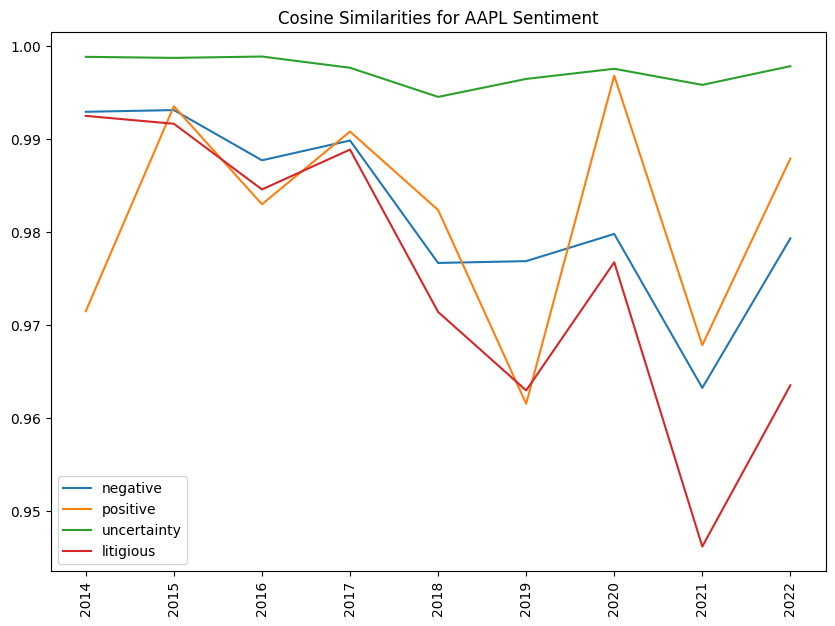

In [10]:
def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement
    # Use k>0 for diagonals above the main diagonal, and k<0 for diagonals below the main diagonal.
    cosine_sim = list(np.diag(cosine_similarity(tfidf_matrix, tfidf_matrix), k=1))
    #print(cosine_sim)
    return cosine_sim

cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

Working with new sentiments list

In [11]:
new_sentiment_tfidf_ten_ks = {}

for company, datalst in data.items():
    lemma_docs = [' '.join(doc) for year, doc in datalst]
    
    new_sentiment_tfidf_ten_ks[company] = {
        sentiment: get_tfidf(new_sentiments_df[new_sentiments_df[sentiment]]['word'], lemma_docs)
        for sentiment in new_sentiments}
    



In [12]:
new_sentiment_bow = {}
for company, datalst in data.items():
    preprocessed_docs = [" ".join(wordlst) for year, wordlst in datalst]
    new_sentiment_bow[company] = {
        sentiment: get_bag_of_words(new_sentiments_df[new_sentiments_df[sentiment]]['word'], preprocessed_docs)
        for sentiment in new_sentiments}
    



In [13]:
doc_scores = {}
for company, sentiment_lst in new_sentiment_bow.items():
    doc_scores[company] = {}
    for sentiment, bows in sentiment_lst.items():
        doc_scores[company][sentiment] = []
        for doc in bows:
            if sentiment == 'positive':
                score = np.sum(doc)/new_sentiments_pos
            elif sentiment == 'negative':
                score = np.sum(doc)/new_sentiments_neg
            elif sentiment == 'uncertainty':
                score = np.sum(doc)/new_sentiments_unc
            doc_scores[company][sentiment].append(score)


doc_scores

{'AXP': {'negative': [1.2181818181818183,
   1.1641025641025642,
   1.1939393939393939,
   1.48997668997669,
   1.3095571095571095,
   1.2857808857808857,
   1.2554778554778554,
   1.1813519813519813,
   1.2941724941724941,
   1.303030303030303,
   1.3128205128205128],
  'positive': [2.6144578313253013,
   2.4819277108433737,
   2.397590361445783,
   3.7068273092369477,
   2.8473895582329316,
   3.004016064257028,
   2.8112449799196786,
   2.5060240963855422,
   2.7751004016064256,
   2.7309236947791167,
   2.7710843373493974],
  'uncertainty': [4.641414141414141,
   4.656565656565657,
   4.762626262626263,
   7.914141414141414,
   7.136363636363637,
   7.156565656565657,
   7.015151515151516,
   6.974747474747475,
   7.0606060606060606,
   7.313131313131313,
   7.353535353535354]},
 'BA': {'negative': [0.7981351981351982,
   0.14918414918414918,
   0.7533799533799533,
   0.14731934731934732,
   0.7258741258741259,
   0.1393939393939394,
   0.7142191142191142,
   0.6815850815850816,
  

In [14]:
result_dict = {}

for ticker, values in doc_scores.items():
    result = []
    for i in range(len(values[new_sentiments[0]])):
        max_sentiment = new_sentiments[0]
        for sentiment in new_sentiments[1:]:
            if values[sentiment][i] > values[max_sentiment][i]:
                max_sentiment = sentiment
        result.append(max_sentiment)
    result_dict[ticker] = result

print(result_dict)

{'AXP': ['uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty'], 'BA': ['uncertainty', 'uncertainty', 'uncertainty', 'negative', 'uncertainty', 'negative', 'uncertainty', 'uncertainty', 'negative', 'uncertainty', 'negative', 'uncertainty', 'negative', 'uncertainty', 'negative', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty'], 'CAT': ['uncertainty', 'uncertainty', 'positive', 'uncertainty', 'uncertainty', 'uncertainty', 'positive', 'uncertainty', 'uncertainty', 'positive', 'uncertainty', 'uncertainty', 'uncertainty', 'positive', 'uncertainty', 'uncertainty', 'uncertainty', 'positive', 'uncertainty', 'uncertainty', 'positive', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty', 'positive', 'uncertainty', 'uncertainty', 'uncertainty', 'uncertainty'], 'KO': ['uncertainty', 'uncertainty', 'uncertainty', 

In [15]:
counts = {}

for key, value in result_dict.items():
    for item in value:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1

print(counts)

{'uncertainty': 93, 'negative': 6, 'positive': 7}


In [16]:
data['AXP'][0][1] # 0 -  year, 1 - doc. We have a list of tuples in AXP

['10',
 'k',
 '1',
 'd486442d10k',
 'htm',
 'form',
 '10',
 'k',
 'form',
 '10',
 'k',
 'table',
 'content',
 'unite',
 'state',
 'securities',
 'exchange',
 'commission',
 'washington',
 'c',
 '20549',
 'form',
 '10',
 'k',
 'þ',
 'annual',
 'report',
 'pursuant',
 'section',
 '13',
 '15',
 'securities',
 'exchange',
 'act',
 '1934',
 'fiscal',
 'year',
 'end',
 'december',
 '31',
 '2012',
 'transition',
 'report',
 'pursuant',
 'section',
 '13',
 '15',
 'securities',
 'exchange',
 'act',
 '1934',
 'transition',
 'period',
 'commission',
 'file',
 '1',
 '7657',
 'american',
 'express',
 'company',
 'exact',
 'name',
 'registrant',
 'specify',
 'charter',
 'new',
 'york',
 '13',
 '4922250',
 'state',
 'jurisdiction',
 'incorporation',
 'organization',
 'r',
 'employer',
 'identification',
 'world',
 'financial',
 'center',
 '200',
 'vesey',
 'street',
 'new',
 'york',
 'new',
 'york',
 '10285',
 'address',
 'principal',
 'executive',
 'offices',
 'zip',
 'code',
 'registrant',
 'teleph

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

final_sentiment_dict = {}
chunk_size = 512

for ticker, datalst in data.items():
    results = []
    for i in range(len(datalst)):
        string = " ".join(data[ticker][i][1])
        
        sentences = [string[i:i+chunk_size] for i in range(0, len(string), chunk_size)]

        results = nlp(sentences)
        # Extract all the 'label' values from the dictionary
        labels = [result['label'] for result in results]

        # Use Counter to count the occurrences of each label
        label_counts = Counter(labels)

        # Get the label that occurs the most
        most_common_label = label_counts.most_common(1)[0][0]
        results.append((data[ticker][i][0], most_common_label))
    final_sentiment_dict[ticker] = results
        

c:\Users\kedar\anaconda3\envs\nlp_stuff\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


KeyboardInterrupt: 

In [ ]:
final_sentiment_dict

In [17]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from collections import Counter
import multiprocessing

def process_sentiment(ticker, datalst):
    finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
    tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

    nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

    final_results = []
    chunk_size = 512

    for i in range(len(datalst)):
        string = " ".join(datalst[i][1])
        sentences = [string[i:i+chunk_size] for i in range(0, len(string), chunk_size)]
        results = nlp(sentences)

        labels = [result['label'] for result in results]
        label_counts = Counter(labels)
        most_common_label = label_counts.most_common(1)[0][0]
        final_results.append((datalst[i][0], most_common_label))

    return ticker, final_results
final_sentiment_dict = {}
if __name__ == '__main__':
    path = './data/pp_doc_dict.pickle'
    data = get_cleaned_data(path) # {company: [(year1, wordlist1), (year2, wordlist2)]}
    data = {k: sorted(v, key=lambda x: x[0]) for k, v in data.items()}


    # Create a pool of processes
    pool = multiprocessing.Pool()

    # Map the data items to the pool of processes
    results = [pool.apply_async(process_sentiment, args=(ticker, datalst)) for ticker, datalst in data.items()]

    # Get the results from the processes
    for result in results:
        ticker, final_results = result.get()
        final_sentiment_dict[ticker] = final_results

    # Close the pool of processes
    pool.close()
    pool.join()

    # Use the final_sentiment_dict as desired


c:\Users\kedar\anaconda3\envs\nlp_stuff\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
